# **Model Training**

## **00. Import Libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

2024-12-02 10:38:21.582752: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## **01. Data Loading**

In [2]:
costs_ml = pd.read_csv("merged_tasks_suppliers.csv").set_index('Task ID')
costs_ml.head()

,Supplier ID,Cost,TF1,TF2,TF3,TF5,TF6,TF7,TF9,TF11,TF13,TF15,TF16,TF17,TF18,TF19,TF20,TF21,TF22,TF23,TF25,TF26,TF27,TF30,TF32,TF33,TF34,TF35,TF36,TF37,TF38,TF39,TF45,TF46,TF47,TF54,TF56,TF57,TF59,TF60,...,TF71,TF73,TF76,TF77,TF78,TF80,TF91,TF94,TF95,TF97,TF99,TF101,TF102,TF103,TF106,TF107,TF110,TF111,TF113,TF114,TF115,TF116,SF1,SF2,SF3,SF4,SF5,SF6,SF7,SF8,SF9,SF10,SF11,SF12,SF13,SF14,SF15,SF16,SF17,SF18
Task ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
T1,S18,0.355652,0.470255,0.589294,0.824272,0.537396,0.70329,0.278689,0.459535,0.4,0.867832,0.666667,0.094796,0.127437,0.229699,0.831366,0.0,0.836371,0.23379,0.765217,0.831996,1.0,0.270607,0.196185,0.207406,0.285051,0.372093,1.0,0.864608,0.772459,0.571429,0.222222,0.956579,0.461538,0.466667,0.650486,0.64888,0.820513,0.574468,0.615176,...,0.51938,0.170109,0.428373,0.410336,1.0,0.333333,0.214215,0.215369,0.245745,0.257977,0.289756,0.394458,0.340138,0.501986,0.012123,0.040193,0.086781,0.1754,0.298052,0.198613,0.469404,0.333333,0.000000,1.0,0.000000,0.090909,1.000000,0.090909,0.666667,0.0,1.000000,0.183673,1.000000,1.000000,0.000000,0.473684,0.230769,0.0,1.00,1.00
T1,S56,0.356349,0.470255,0.589294,0.824272,0.537396,0.70329,0.278689,0.459535,0.4,0.867832,0.666667,0.094796,0.127437,0.229699,0.831366,0.0,0.836371,0.23379,0.765217,0.831996,1.0,0.270607,0.196185,0.207406,0.285051,0.372093,1.0,0.864608,0.772459,0.571429,0.222222,0.956579,0.461538,0.466667,0.650486,0.64888,0.820513,0.574468,0.615176,...,0.51938,0.170109,0.428373,0.410336,1.0,0.333333,0.214215,0.215369,0.245745,0.257977,0.289756,0.394458,0.340138,0.501986,0.012123,0.040193,0.086781,0.1754,0.298052,0.198613,0.469404,0.333333,0.000000,0.0,1.000000,0.090909,0.090909,0.090909,1.000000,1.0,1.000000,0.000000,0.000000,0.571429,0.473684,1.000000,0.230769,0.0,0.15,1.00
T1,S47,0.357635,0.470255,0.589294,0.824272,0.537396,0.70329,0.278689,0.459535,0.4,0.867832,0.666667,0.094796,0.127437,0.229699,0.831366,0.0,0.836371,0.23379,0.765217,0.831996,1.0,0.270607,0.196185,0.207406,0.285051,0.372093,1.0,0.864608,0.772459,0.571429,0.222222,0.956579,0.461538,0.466667,0.650486,0.64888,0.820513,0.574468,0.615176,...,0.51938,0.170109,0.428373,0.410336,1.0,0.333333,0.214215,0.215369,0.245745,0.257977,0.289756,0.394458,0.340138,0.501986,0.012123,0.040193,0.086781,0.1754,0.298052,0.198613,0.469404,0.333333,0.000000,0.0,0.473684,0.000000,0.000000,0.000000,0.666667,1.0,0.000000,0.183673,0.473684,0.000000,0.000000,0.000000,0.000000,0.6,1.00,0.75
T1,S27,0.367182,0.470255,0.589294,0.824272,0.537396,0.70329,0.278689,0.459535,0.4,0.867832,0.666667,0.094796,0.127437,0.229699,0.831366,0.0,0.836371,0.23379,0.765217,0.831996,1.0,0.270607,0.196185,0.207406,0.285051,0.372093,1.0,0.864608,0.772459,0.571429,0.222222,0.956579,0.461538,0.466667,0.650486,0.64888,0.820513,0.574468,0.615176,...,0.51938,0.170109,0.428373,0.410336,1.0,0.333333,0.214215,0.215369,0.245745,0.257977,0.289756,0.394458,0.340138,0.501986,0.012123,0.040193,0.086781,0.1754,0.298052,0.198613,0.469404,0.333333,0.090909,1.0,0.473684,0.090909,0.000000,0.090909,1.000000,1.0,0.473684,0.000000,0.000000,1.000000,0.473684,0.473684,0.000000,1.0,0.02,0.75
T1,S34,0.367398,0.470255,0.589294,0.824272,0.537396,0.70329,0.278689,0.459535,0.4,0.867832,0.666667,0.094796,0.127437,0.229699,0.831366,0.0,0.836371,0.23379,0.765217,0.831996,1.0,0.270607,0.196185,0.207406,0.285051,0.372093,1.0,0.864608,0.772459,0.571429,0.222222,0.956579,0.461538,0.466667,0.650486,0.64888,0.820513,0.574468,0.615176,...,0.51938,0.170109,0.428373,0.410336,1.0,0.333333,0.214215,0.215369,0.245745,0.257977,0.289756,0.394458,0.340138,0.501986,0.012123,0.040193,0.086781,0.1754,0.298052,0.198613,0.469404,0.333333,0.000000,1.0,0.473684,1.000000,0.000000,1.000000,0.333333,0.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.473684,1.000000,0.6,0.30,0.75


## **02. Data Preparation**

Split the data into X, Y and Groups (Task ID)

In [4]:
X = costs_ml.drop(columns=['Supplier ID', 'Cost'])
y = costs_ml['Cost']
groups = pd.DataFrame(costs_ml.index)

Selecting 20 Tasks Randomly (Test Group)

In [5]:
np.random.seed(77)
test_group = pd.Series(groups['Task ID'].unique()).sample(20)
test_group.values

array(['T103', 'T6', 'T21', 'T111', 'T4', 'T50', 'T82', 'T63', 'T55',
       'T89', 'T107', 'T19', 'T58', 'T62', 'T5', 'T46', 'T123', 'T114',
       'T88', 'T79'], dtype=object)

Splitting the data

In [6]:
X_train = X[~X.index.isin(test_group)]
y_train= y[~y.index.isin(test_group)]
X_test = X[X.index.isin(test_group)]
y_test = y[y.index.isin(test_group)]

print("Size X_train data:",X_train.shape)
print("Size y_train data:",y_train.shape)
print("Size X_test data:",X_test.shape)
print("Size y_test data:",y_test.shape)
print(f"\n The test set is {X_test.shape[0]*100/X.shape[0]:.2f}% of the data")

Size X_train data: (5900, 85)
Size y_train data: (5900,)
Size X_test data: (1180, 85)
Size y_test data: (1180,)

 The training set is 16.67% of the data


## **03. Model Training**

In [8]:
# Neural Network
nn_model = Sequential()
nn_model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
nn_model.add(Dense(32, activation='relu'))
nn_model.add(Dense(1, activation='linear'))
nn_model.compile(optimizer='adam', loss='mean_squared_error')
nn_model.fit(X_train, y_train, epochs=100, batch_size=10, verbose=0)
y_pred_nn = nn_model.predict(X_test).flatten()

37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [20]:
# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=17)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# K-Nearest Neighbors
knn_model = KNeighborsRegressor(n_neighbors=7)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Gradient Boosting
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=17)
gb_model.fit(X_train, y_train)
y_pred_gb = gb_model.predict(X_test)

## **04. Model Evaluation**

In [21]:
def calc_rmse(y_test, y_pred):
    """
    Calculate the Root Mean Squared Error (RMSE) manually.
    
    Parameters:
    y_true (array-like): True values
    y_pred (array-like): Predicted values
    
    Returns:
    float: RMSE value
    """
    mse = np.mean((y_test - y_pred) ** 2)
    rmse = np.sqrt(mse)
    return rmse

In [22]:
# Calculate RMSE for each model
rmse_nn = calc_rmse(y_test, y_pred_nn)
rmse_rf = calc_rmse(y_test, y_pred_rf)
rmse_knn = calc_rmse(y_test, y_pred_knn)
rmse_gb = calc_rmse(y_test, y_pred_gb)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': ['Neural Network', 'Random Forest', 'K-Nearest Neighbors', 'Gradient Boosting'],
    'RMSE': [rmse_nn, rmse_rf, rmse_knn, rmse_gb]
})

results_df

,Model,RMSE
0,Neural Network,0.022676
1,Random Forest,0.023555
2,K-Nearest Neighbors,0.023106
3,Gradient Boosting,0.021742


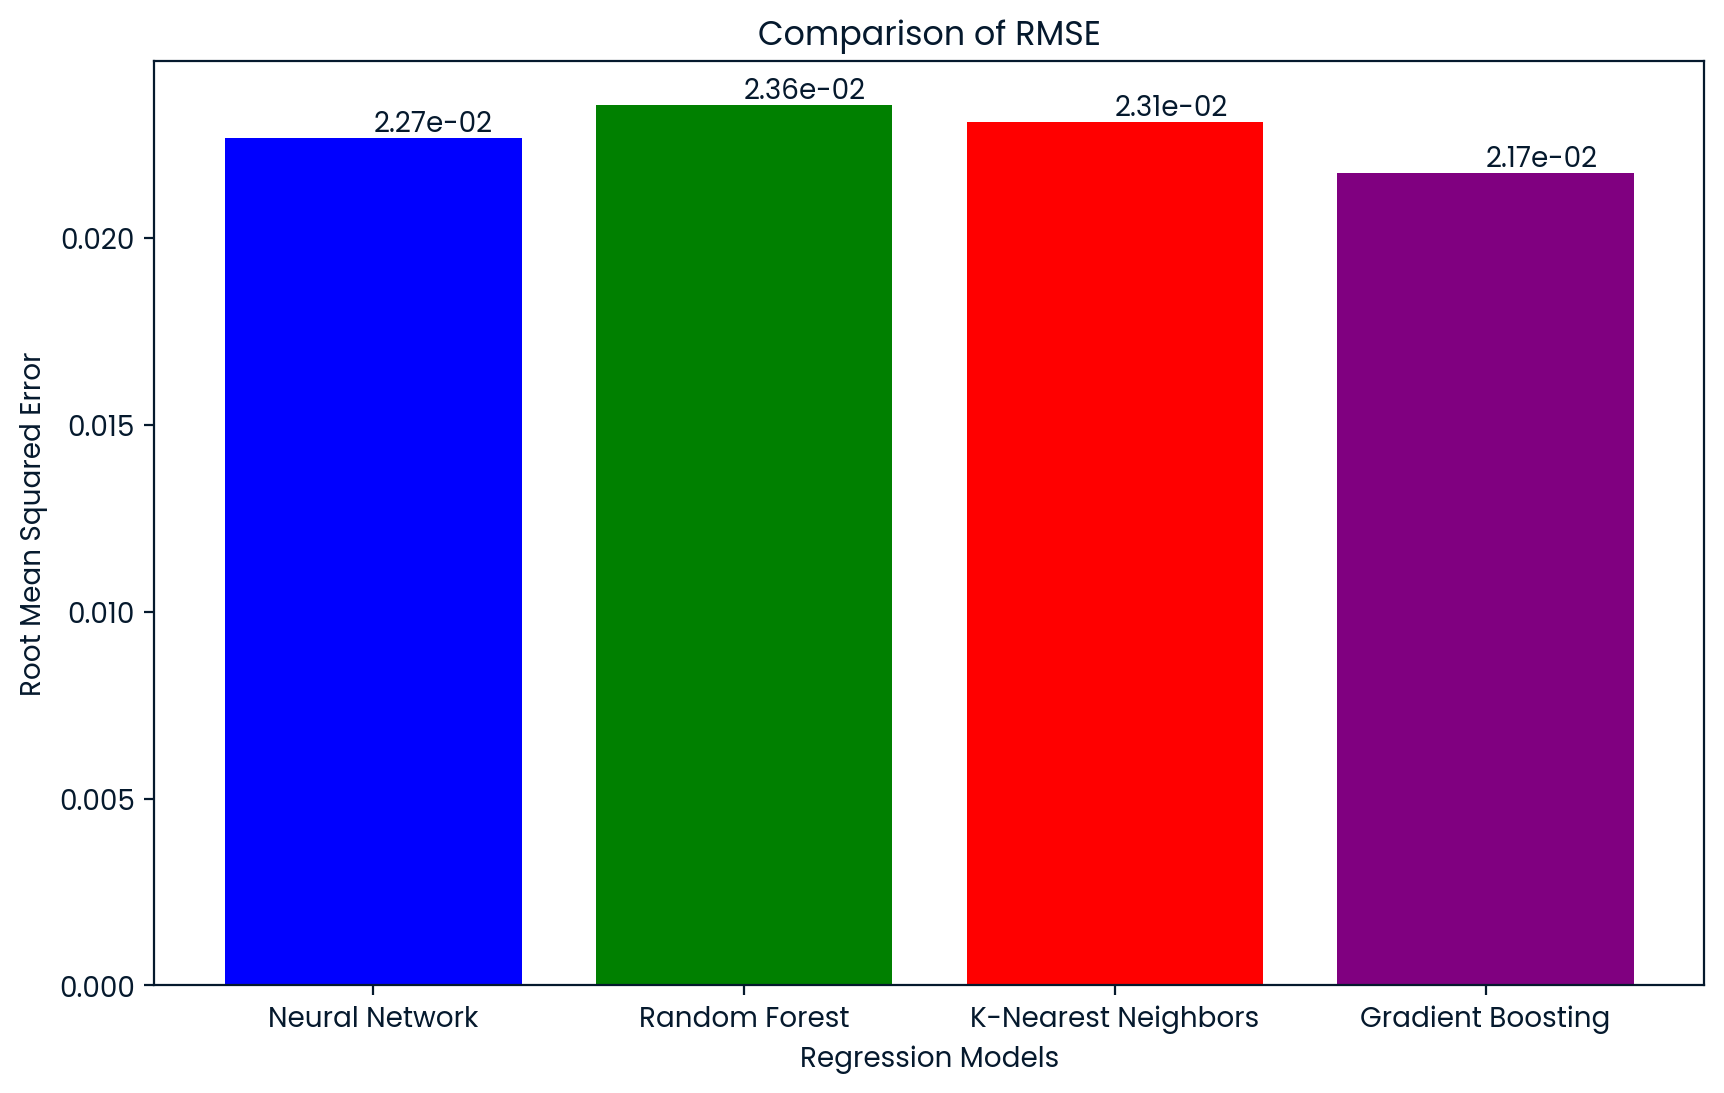

In [23]:
# Error results
mse_values = [rmse_nn, rmse_rf, rmse_knn, rmse_gb]
model_names = ['Neural Network', 'Random Forest', 'K-Nearest Neighbors', 'Gradient Boosting']

# Plotting the MSE values
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, mse_values, color=['blue', 'green', 'red', 'purple'])

# Adding value labels on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, f'{yval:.2e}', va='bottom')

plt.xlabel('Regression Models')
plt.ylabel('Root Mean Squared Error')
plt.title('Comparison of RMSE')
plt.show()